In [23]:
# Data Processing
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit

# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from statsmodels.api import OLS

import openpyxl
import math

In [74]:
# Predicts y_test data according to the given model
def evaluate_model(model, X_test, y_test):
    # Make predictions on the test set
    test_predictions = model.predict(X_test)
    
    # Ensure the lengths match by applying the mask to both predictions and actual values
    # Define a very small value to replace zeros
    small_value = 1e-100
    
    # Replace 0 values with the small value in both predictions and actual values
    test_predictions = np.where(test_predictions == 0, small_value, test_predictions)
    y_test_filtered = np.where(y_test == 0, small_value, y_test)

    
    return test_predictions, y_test_filtered

In [25]:
# Prints statistics of prediction
def print_stats(y_test, predictions):
    print('Mean Squared Error (MSE):', mean_squared_error(y_test, predictions))
    print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, predictions)))
    mape = np.mean(np.abs((y_test - predictions) / np.abs(y_test)))
    print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
    print('Accuracy:', round(100 * (1 - mape), 2))

    correlation_coefficient, p_value = spearmanr(y_test, predictions)
    print(f"\nSpearman Rho:{correlation_coefficient}\np-value:{p_value}")
    
    correlation_coefficient, p_value = pearsonr(y_test, predictions)
    print(f"\nPearson Rho:{correlation_coefficient}\np-value:{p_value}")

In [26]:
def merge_identical_xlsx_columns(df, col_name1, col_name2, merged_col_name):
    df[merged_col_name] = df[col_name1].fillna(df[col_name2])
    if merged_col_name == col_name1:
        df.drop(col_name2, axis=1, inplace=True)
    elif merged_col_name == col_name2:
        df.drop(col_name1, axis=1, inplace=True)
    else:
        df.drop([col_name1, col_name2], axis=1, inplace=True)
    return df

In [27]:
# Finds and most reliable Cell lines 
# retrieves a dict cell lines with deviations between doubling of different labs less than diff_pecentage
def get_reliable_cell_lines(df, df2, allowed_diff_percentage):
    reliable_cell_lines = {}
    for index, row in df2.iterrows():
        matching_row = df[df['DepMap ID'] == row['Parental cell line ID']] # find correlating row in original data
        if not matching_row.empty:
            original_val = matching_row.iloc[0]['Doubling Time (hrs)'].item()
            ccle_val = row['CCLE Doubling Time (hrs)']
            gpp_val = row['GPP (screeners) Cell Doubling Time (hrs)']
            depmap_val = row['DepMap expansion Doubling time (hrs)']
            
            arr = np.array([original_val, ccle_val, gpp_val, depmap_val])
            arr = arr[~np.isnan(arr)]
            # The lower measured value is at least (100-x)% of the higher measured value
            is_min_at_least_percent_of_max = lambda arr: np.min(arr) >= (100-allowed_diff_percentage)/100 * np.max(arr)
            if is_min_at_least_percent_of_max(arr):
                reliable_cell_lines[matching_row.iloc[0]['DepMap ID']] = float(np.nanmean(arr))
    return reliable_cell_lines 

Load and Clean Data

In [28]:
# Load original clinical data file
df = pd.read_csv('./DATA/ccle_broad_2019/ccle_broad_2019_clinical_data.csv')
df.head()

,Study ID,Patient ID,Sample ID,Age,Annotation Source,Cancer Type,Cancer Type Detailed,Cell Line Source,Characteristics,DepMap ID,...,Sex,Site of Finding,Site Subtype 1,Site Subtype 2,Site Subtype 3,Subtype,Supplements,TMB (nonsynonymous),Tumor Type,Type Refined
0,ccle_broad_2019,127399_SOFT_TISSUE,127399_SOFT_TISSUE,NaN,NaN,Soft Tissue Sarcoma,Synovial Sarcoma,NaN,NaN,ACH-001270,...,NaN,NaN,NaN,NaN,NaN,Synovial,NaN,5.533333,NaN,NaN
1,ccle_broad_2019,1321N1_CENTRAL_NERVOUS_SYSTEM,1321N1_CENTRAL_NERVOUS_SYSTEM,NaN,CCLE,Glioma,Astrocytoma,NaN,NaN,ACH-001000,...,NaN,NaN,brain,NS,NS,Astrocytoma,NaN,NaN,glioma,glioma
2,ccle_broad_2019,143B_BONE,143B_BONE,13.0,CCLE,Bone Cancer,Osteosarcoma,NaN,NaN,ACH-001001,...,Female,NaN,NS,NS,NS,Osteosarcoma,NaN,NaN,osteosarcoma,osteosarcoma
3,ccle_broad_2019,201T_LUNG,201T_LUNG,NaN,NaN,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,ACH-002089,...,NaN,NaN,NaN,NaN,NaN,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NaN,10.100000,NaN,lung_NSC
4,ccle_broad_2019,22RV1_PROSTATE,22RV1_PROSTATE,NaN,CCLE,Prostate Cancer,Prostate Adenocarcinoma,ATCC,Adherent epithelial,ACH-000956,...,Male,NaN,NS,NS,NS,Adenocarcinoma,NaN,73.700000,prostate,prostate


In [29]:
# Load second clinical data file
df2 = pd.read_excel('./DATA/merged_doubling_time_with_site.xlsx')
df2 = merge_identical_xlsx_columns(df2, "CCLE Doubling Time (hrs)","Doubling.Time.Calculated.hrs",
                                    "CCLE Doubling Time (hrs)")
df2.head()

,Parental cell line ID,Cell Line Name,GPP (screeners) Cell Doubling Time (hrs),DepMap expansion Doubling time (hrs),CCLE Doubling Time (hrs),Site_Primary
0,ACH-000014,Hs294T,66.0,NaN,67.5,skin
1,ACH-000021,NCIH1693,50.0,NaN,94.7,lung
2,ACH-000022,PATU8988S,36.0,NaN,110.0,pancreas
3,ACH-000025,CH157MN,35.0,NaN,NaN,central_nervous_system
4,ACH-000037,S117,45.0,NaN,107.6,soft_tissue


In [30]:
reliable_cell_lines = get_reliable_cell_lines(df=df, df2=df2, allowed_diff_percentage=50)
len(reliable_cell_lines)
#reliable_cell_lines


777

Note:
df2 contains 3 columns with doubling time:
“GPP (screeners) Cell Doubling Time (hrs)”
“DepMap expansion Doubling time (hrs)”
“CCLE Doubling Time (hrs)”

In [31]:
for cell_line_name, doubling_time in reliable_cell_lines.items():
    matching_row = df[df['DepMap ID'] == cell_line_name] # find correlating row in original data
    if not matching_row.empty:
        df.loc[matching_row.index, 'Doubling Time (hrs)'] = doubling_time

df_cleaned = df.dropna(subset=['Doubling Time (hrs)']) # Clean 'NA' labels
patient_IDs = df_cleaned["Patient ID"].tolist() # who was left after cleaning NA

df_cleaned.head()

# Save DataFrame to a CSV file
#df_cleaned.to_csv('output.csv', index=False)
#len(patient_IDs)

,Study ID,Patient ID,Sample ID,Age,Annotation Source,Cancer Type,Cancer Type Detailed,Cell Line Source,Characteristics,DepMap ID,...,Sex,Site of Finding,Site Subtype 1,Site Subtype 2,Site Subtype 3,Subtype,Supplements,TMB (nonsynonymous),Tumor Type,Type Refined
0,ccle_broad_2019,127399_SOFT_TISSUE,127399_SOFT_TISSUE,NaN,NaN,Soft Tissue Sarcoma,Synovial Sarcoma,NaN,NaN,ACH-001270,...,NaN,NaN,NaN,NaN,NaN,Synovial,NaN,5.533333,NaN,NaN
2,ccle_broad_2019,143B_BONE,143B_BONE,13.0,CCLE,Bone Cancer,Osteosarcoma,NaN,NaN,ACH-001001,...,Female,NaN,NS,NS,NS,Osteosarcoma,NaN,NaN,osteosarcoma,osteosarcoma
4,ccle_broad_2019,22RV1_PROSTATE,22RV1_PROSTATE,NaN,CCLE,Prostate Cancer,Prostate Adenocarcinoma,ATCC,Adherent epithelial,ACH-000956,...,Male,NaN,NS,NS,NS,Adenocarcinoma,NaN,73.700000,prostate,prostate
5,ccle_broad_2019,2313287_STOMACH,2313287_STOMACH,72.0,CCLE,Esophagogastric Cancer,Stomach Adenocarcinoma,DSMZ,aderent epithelial cells growing as confluent ...,ACH-000948,...,Male,NaN,NS,NS,NS,Adenocarcinoma,NaN,76.266667,stomach,stomach
8,ccle_broad_2019,42MGBA_CENTRAL_NERVOUS_SYSTEM,42MGBA_CENTRAL_NERVOUS_SYSTEM,63.0,CCLE,Glioma,Astrocytoma,DSMZ,Adherent,ACH-000323,...,Male,NaN,brain,NS,NS,Astrocytoma,NaN,7.033333,glioma,glioma


In [32]:
# Load RNA expression data (use Reads Per Kilobase data)
expression_df = pd.read_csv('./DATA/ccle_broad_2019/data_mrna_seq_rpkm.txt',  sep='\t')

In [33]:
# Remove patients with NA Doubling Time
selected_columns = ['Hugo_Symbol'] + [col for col in patient_IDs if col in expression_df.columns]
expression_df = expression_df[selected_columns]
expression_df.head()

,Hugo_Symbol,127399_SOFT_TISSUE,143B_BONE,22RV1_PROSTATE,2313287_STOMACH,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,...,YAMATO_SOFT_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
0,DDX11L1,0.08018,0.00000,0.00000,0.03755,0.00000,0.01378,0.01463,0.03085,0.00000,...,0.00000,0.00000,0.00000,0.07603,0.00000,0.04757,0.00000,0.08533,0.26518,0.01725
1,WASH7P,7.22956,11.75542,12.63011,10.14155,7.61752,6.19356,4.62277,6.00767,4.70699,...,11.81688,4.57684,9.38655,6.16807,5.25951,7.25056,6.15860,7.83898,14.24817,7.94108
2,MIR1302-11,0.05536,0.36737,0.04289,0.01037,0.08765,0.00000,0.00808,0.09373,0.02568,...,0.17586,0.07086,0.19758,0.00000,0.00000,0.15767,0.00000,0.14140,0.01831,0.00000
3,FAM138A,0.00000,0.00932,0.00000,0.00869,0.00000,0.00637,0.00000,0.01427,0.00000,...,0.02266,0.00000,0.00000,0.00000,0.00000,0.00000,0.01719,0.17371,0.00000,0.00000
4,OR4G4P,0.01194,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.01459,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [34]:
 # sort by patient ID
expression_df_sorted = expression_df[expression_df.columns[0]].to_frame().join(expression_df[expression_df.columns[1:]].sort_index(axis=1))
df_cleaned_sorted = df_cleaned.sort_values(by='Patient ID')
#df_cleaned_sorted

In [35]:
# Get all column names except for the first one and store them in a list
patient_ID_list = expression_df_sorted.columns[1:].tolist()

# Filter out rows where 'Patient ID' is not in the allowed list
df_cleaned_sorted_filtered = df_cleaned_sorted[df_cleaned_sorted['Patient ID'].isin(patient_ID_list)]

num_rows, num_columns = df_cleaned_sorted_filtered.shape
print(f'Successfully loaded data.\nNumber of rows:{num_rows}\nNumber of columns:{num_columns-1}')
#print(df_cleaned_sorted_filtered.head())

Successfully loaded data.
Number of rows:928
Number of columns:50


In [36]:
# Prepare counts
counts = expression_df_sorted
counts.set_index('Hugo_Symbol', inplace=True)
counts = counts[counts.sum(axis=1) > 0]   #remove rows containing only 0

# Transpose the DataFrame to have samples as rows and genes as columns
counts = counts.T #(=x.train)
counts.index.name = 'Sample'

In [37]:
# prepare metadata (=y.train)
metadata = pd.DataFrame(zip(counts.index, df_cleaned_sorted_filtered['Doubling Time (hrs)']),
                        columns=['Sample', 'Doubling Time (hrs)'])
metadata = metadata.set_index('Sample')

In [38]:
metadata = metadata.sort_index()
metadata.shape

(928, 1)

In [39]:
counts = counts.sort_index()
counts.shape

(928, 53758)

In [40]:
counts.head()

Hugo_Symbol,DDX11L1,WASH7P,MIR1302-11,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,CICP27,AL627309.1,...,MT-ND3,MT-TR,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT
Sample,,,,,,,,,,,,,,,,,,,,,
127399_SOFT_TISSUE,0.08018,7.22956,0.05536,0.00000,0.01194,0.0,0.02463,0.08245,0.07118,0.22517,...,852.71008,0.00000,0.65539,0.57485,0.00000,627.78180,359.01724,0.49154,1396.61133,0.00000
143B_BONE,0.00000,11.75542,0.36737,0.00932,0.00000,0.0,0.00000,0.10132,0.20574,1.93494,...,1042.40210,0.17486,0.16473,0.00000,0.00000,462.55017,248.79994,0.16473,736.91791,0.17221
22RV1_PROSTATE,0.00000,12.63011,0.04289,0.00000,0.00000,0.0,0.00000,0.44714,0.37909,6.17780,...,1176.81189,0.00000,0.00000,0.00000,0.12335,2393.80298,1825.52332,0.25386,4923.78223,0.00000
2313287_STOMACH,0.03755,10.14155,0.01037,0.00869,0.00000,0.0,0.00000,0.34327,0.09168,6.56648,...,1009.34979,0.00000,0.00000,0.00000,0.00000,1960.96802,2056.64697,0.00000,3827.00537,0.00000
42MGBA_CENTRAL_NERVOUS_SYSTEM,0.00000,7.61752,0.08765,0.00000,0.00000,0.0,0.00000,0.09428,0.07513,1.01231,...,1049.68384,0.13768,0.00000,0.00000,0.25209,1178.93579,1616.96484,0.12970,2343.92407,0.00000


Get Features (Genes)

In [41]:
cancer_marker_genes = [
    'RB1', 'PIK3CA', 'BRAF', 'CTNNB1', 'CDKN2A', 'MLH1', 'APC', 'BRCA2', 
    'BRCA1', 'FGFR3', 'KRAS', 'EGFR', 'ATM', 'VHL', 'MET', 'PTEN', 'TP53', 'ERBB2'
]

genes = cancer_marker_genes
#rhos, pvals = [], []

# Loop through each gene column
for gene_idx in range(counts.shape[1]):
    gene_expression = counts.iloc[:, gene_idx].tolist() # Extract the gene expression levels for the current gene
    correlation_coefficient, p_value = pearsonr(gene_expression, metadata['Doubling Time (hrs)'].tolist())
    if abs(correlation_coefficient) >= 0.37 and p_value <= 0.05:
        genes.append(counts.columns[gene_idx])
        #pvals.append(p_value)
        #rhos.append(correlation_coefficient)

selected_genes = counts[counts.columns[counts.columns.isin(genes)]]


In [42]:
#Add cancer type as feature

# Step 1: Reset the index to make 'Sample' a column
selected_genes.reset_index(inplace=True)

# Step 2: Perform the merge
selected_genes = selected_genes.merge(df_cleaned[['Patient ID', 'Cancer Type']],
                      left_on='Sample', right_on='Patient ID',
                      how='left')

# Step 3: Set 'Sample' back as the index
selected_genes.set_index('Sample', inplace=True)

# Step 4: Optionally, drop 'Patient ID' column if it's no longer needed
selected_genes.drop(columns=['Patient ID'], inplace=True)

,RN7SL503P,MANEAL,RP11-109P14.9,OXCT2,MIR5008,VHL,MLH1,CTNNB1,RP11-64C1.1,PIK3CA,...,PTEN,ATM,KRAS,BRCA2,RB1,TP53,ERBB2,BRCA1,LUZP4,Cancer Type
Sample,,,,,,,,,,,,,,,,,,,,,
127399_SOFT_TISSUE,0.00000,1.37104,2.08343,1.24446,0.0,13.13018,23.03053,57.32386,0.0,4.10409,...,8.89652,3.55268,2.88473,2.23479,21.47724,39.08976,12.51507,6.88848,0.00000,Soft Tissue Sarcoma
143B_BONE,0.00000,14.57490,20.32920,0.30501,0.0,11.25016,22.96783,52.18494,0.0,4.78646,...,8.03629,3.88041,146.76906,1.62359,13.33342,43.41837,5.28352,12.92010,0.00658,Bone Cancer
22RV1_PROSTATE,0.05858,21.30927,30.11565,0.21584,0.0,20.68454,34.96470,83.25976,0.0,5.81124,...,12.57388,6.93570,8.49693,3.69599,21.03547,7.53691,13.28823,27.93248,0.00000,Prostate Cancer
2313287_STOMACH,0.00000,4.13702,5.85472,0.08119,0.0,22.44926,0.06400,78.60170,0.0,7.65124,...,21.21800,7.06170,6.70680,3.50567,21.09570,45.59394,27.55733,8.32077,0.00000,Esophagogastric Cancer
42MGBA_CENTRAL_NERVOUS_SYSTEM,0.00000,7.03966,7.49187,0.43129,0.0,9.82238,18.95712,63.38434,0.0,5.57387,...,2.45971,10.26828,1.98372,1.65218,1.13504,13.92053,6.64785,3.51526,0.00000,Glioma


In [43]:
# Convert categorical string values to dummies
selected_genes = pd.get_dummies(selected_genes[['Cancer Type']])
selected_genes.head()

,Cancer Type_Adrenocortical Carcinoma,Cancer Type_B-Lymphoblastic Leukemia/Lymphoma,Cancer Type_Bladder Cancer,Cancer Type_Bone Cancer,Cancer Type_Breast Cancer,Cancer Type_CNS Cancer,Cancer Type_Cervical Cancer,"Cancer Type_Cervical Cancer, NOS",Cancer Type_Colorectal Cancer,Cancer Type_Embryonal Tumor,...,Cancer Type_Retinoblastoma,Cancer Type_Rhabdoid Cancer,Cancer Type_Salivary Gland Cancer,"Cancer Type_Skin Cancer, Non-Melanoma",Cancer Type_Small Bowel Cancer,Cancer Type_Small Cell Lung Cancer,Cancer Type_Soft Tissue Sarcoma,Cancer Type_T-Lymphoblastic Leukemia/Lymphoma,Cancer Type_Thyroid Cancer,Cancer Type_Uterine Sarcoma
Sample,,,,,,,,,,,,,,,,,,,,,
127399_SOFT_TISSUE,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
143B_BONE,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
22RV1_PROSTATE,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2313287_STOMACH,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
42MGBA_CENTRAL_NERVOUS_SYSTEM,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Train Models and Predict

In [44]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(selected_genes, metadata['Doubling Time (hrs)'], test_size=0.2, random_state=42)

In [ ]:
############## Random Forest ##############
print("\n--- Random Forest ---\n")

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'absolute_error'],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],
    
}

# Create the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

# Chosen scoring method
scoring_method = 'd2_absolute_error_score'

# Create the GridSearchCV object (Cost validation)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scoring_method, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

In [75]:
# Evaluate the best model
predictions, y_test_filtered = evaluate_model(best_rf_model, X_test, y_test)

# Evaluate
#print_stats(np.log10(y_test_filtered), np.log10(predictions))
print_stats(y_test_filtered, predictions)

Mean Squared Error (MSE): 2513.8518626364285
Root Mean Squared Error (RMSE): 50.13832728199484
Mean Absolute Percentage Error (MAPE): 31.93
Accuracy: 68.07

Spearman Rho:0.25211565835226896
p-value:0.0005176211849132595

Pearson Rho:0.36521860675145246
p-value:2.9673881211239214e-07


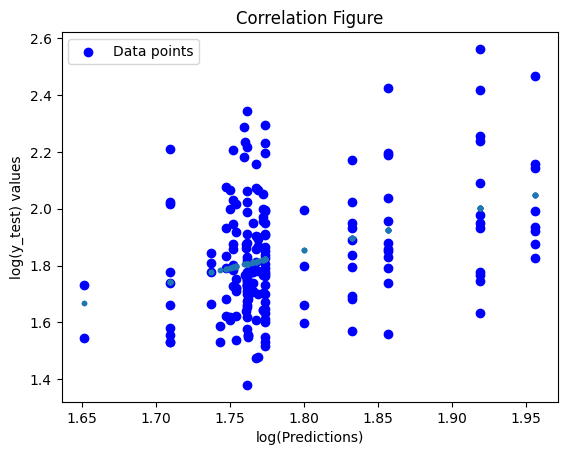

In [76]:
# Correlation Figure
plt.scatter(np.log10(predictions), np.log10(y_test_filtered), color='blue', label='Data points')
b, m = polyfit(np.log10(predictions), np.log10(y_test_filtered), 1) # Fit with polyfit
plt.plot(np.log10(predictions), b + m * np.log10(predictions), '.')
plt.xlabel('log(Predictions)')
plt.ylabel('log(y_test) values')
plt.title('Correlation Figure')
plt.legend()
plt.show()

In [102]:
test_df = y_test.to_frame()
test_df['Prediction'] = predictions
test_df

,Doubling Time (hrs),Prediction
Sample,,
SLR26_KIDNEY,61.000000,56.513140
PK1_PANCREAS,49.466667,68.021085
AML193_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,79.533333,58.791483
KYSE180_OESOPHAGUS,34.066667,55.411353
GCT_SOFT_TISSUE,64.600000,54.653545
...,...,...
LK2_LUNG,71.000000,59.432979
5637_URINARY_TRACT,52.600000,56.782552
BLUE1_HAEMATOPOIETIC_AND_LYMPHOID,46.000000,57.745222


In [104]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(selected_genes, metadata['Doubling Time (hrs)'], test_size=0.2, random_state=42)

In [105]:
############## Linear Regression ##############
print("\n--- Linear Regression ---\n")

lr_model = LinearRegression() #uses gradient descent internally
lr_model.fit(X_train, y_train)

# Evaluate the model
predictions, y_test_filtered = evaluate_model(lr_model, X_test, y_test)

# Evaluate
#print_stats(np.log10(y_test_filtered), np.log10(predictions))
print_stats(y_test_filtered, predictions)


--- Linear Regression ---

Mean Squared Error (MSE): 1.7826164221572923e+25
Root Mean Squared Error (RMSE): 4222104240964.797
Mean Absolute Percentage Error (MAPE): 893841447634.19
Accuracy: -893841447534.19

Spearman Rho:0.16658450316393436
p-value:0.023056541281591975

Pearson Rho:-0.06335050450454303
p-value:0.39032696265869143


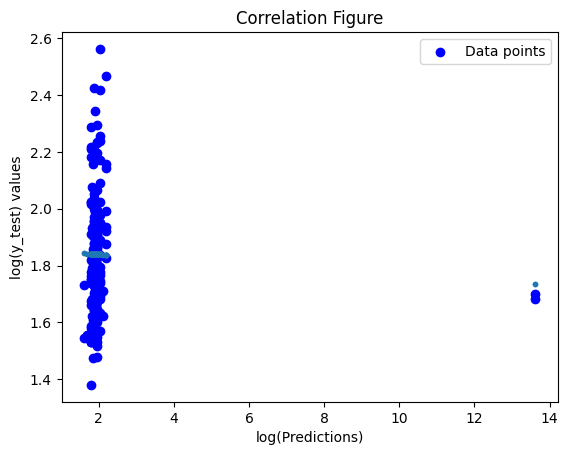

In [106]:
# Correlation Figure

plt.scatter(np.log10(predictions), np.log10(y_test_filtered), color='blue', label='Data points')
b, m = polyfit(np.log10(predictions), np.log10(y_test_filtered), 1) # Fit with polyfit
plt.plot(np.log10(predictions), b + m * np.log10(predictions), '.')
plt.xlabel('log(Predictions)')
plt.ylabel('log(y_test) values')
plt.title('Correlation Figure')
plt.legend()
plt.show()

In [107]:
test_df = y_test.to_frame()
test_df['Prediction'] = predictions
test_df

,Doubling Time (hrs),Prediction
Sample,,
SLR26_KIDNEY,61.000000,73.765625
PK1_PANCREAS,49.466667,106.023438
AML193_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,79.533333,91.718750
KYSE180_OESOPHAGUS,34.066667,63.585938
GCT_SOFT_TISSUE,64.600000,70.937500
...,...,...
LK2_LUNG,71.000000,90.710938
5637_URINARY_TRACT,52.600000,81.882812
BLUE1_HAEMATOPOIETIC_AND_LYMPHOID,46.000000,79.406250
